# 2022-09-13 • Fit simpler model to STA

## Imports

In [1]:
#

In [2]:
using Revise

In [3]:
using MyToolbox

In [4]:
using VoltoMapSim

## Params

In [5]:
p = get_params(
    duration = 10minutes,
    p_conn = 0.04,
    g_EE = 1,
    g_EI = 1,
    g_IE = 4,
    g_II = 4,
    ext_current = Normal(-0.5 * pA/√seconds, 5 * pA/√seconds),
    E_inh = -80 * mV,
    record_v = [1:40; 801:810],
);

## Run sim

In [6]:
s = cached(sim, [p.sim]);

In [7]:
s = augment(s, p);

## Model function

See end of previous notebook.

We're gonna repeat that notebook but with an altered and simplified model function.

Subfunctions, as before:

In [8]:
linear_PSP(t; τ1, τ2) =
    
    if (τ1 == τ2)   @. t * exp(-t/τ1)
    else            @. τ1*τ2/(τ1-τ2) * (exp(-t/τ1) - exp(-t/τ2))
    end;

In [100]:
gaussian(x; loc, width) =  

    @. exp(-0.5*( (x-loc)/width )^2);

# Note that unlike in the previous notebook, we do add the 1/2 factor in the exponent here

In [101]:
rescale_to_max!(x) = 
    
    x ./= maximum(abs.(x));

# Note that this returns `NaN`s if x .== 0

In [102]:
centre!(x) = (x .-= mean(x))
centre(x) = centre!(copy(x));

In [103]:
mult!(by) = x -> (x .*= by);

In [104]:
p0 = CVec(
    tx_delay   = 10ms,
    bump = (
        τ1     = 10ms,
        τ2     = 12ms
    ),
    dip = (
        loc    = 40ms,
        width  = 3,
        weight = 0.15,
    ),
    scale      = 0mV,
);
# `dip.loc` is relative to `tx_delay`
# The variance (width) of the dip's gaussian is `dip.width * mean(τ1, τ2)`

FitParams = typeof(p0);

In [105]:
pbounds = CVec(
    tx_delay   = [0, 60ms],
    bump = (
        τ1     = [0, 100ms],
        τ2     = [0, 100ms],
    ),
    dip = (
        loc    = [10ms, 70ms],
        width  = [1, 5],
        weight = [0  , 1],
    ),
    scale      = [-2mV, 2mV],
)
pb_flat = collect(CVec(pbounds))
lower = pb_flat[1:2:end]
upper = pb_flat[2:2:end];

In [106]:
function model_STA_components(ep::ExpParams, fp::FitParams)

    Δt::Float64  = p.sim.general.Δt
    STA_duration = p.conntest.STA_window_length

    @unpack tx_delay, bump, dip = fp
    
    PSP_duration = STA_duration - tx_delay

    delay_size = round(Int, tx_delay / Δt)
    PSP_size   = round(Int, PSP_duration / Δt)
    STA_size   = round(Int, STA_duration / Δt)

    t_PSP = collect(linspace(0, PSP_duration, PSP_size))
    t_STA = collect(linspace(0, STA_duration, STA_size))
    
    τ1, τ2 = bump
    loc    = dip.loc + tx_delay
    width  = dip.width * (τ1+τ2)/2
    
    add_delay(x) = vcat(zeros(Float64, delay_size), x)
    
    bump = (
        linear_PSP(t_PSP; τ1, τ2)
        |> rescale_to_max!
        |> add_delay
    )
    
    dip = (
        gaussian(t_STA; loc, width)
        |> rescale_to_max!
        |> mult!(-dip.weight)
    )
    
    return (; bump, dip)
end


function model_STA(ep::ExpParams, fp::FitParams)
    bump, dip = model_STA_components(ep, fp)
    STA = (
        bump .+ dip
        |> mult!(fp.scale)
        |> centre!
    )
end;

(A slightly smarter way than `rescale_to_max!`, with its `maximum` search, would be to analytically calculate the maximum heights of the linear_PSP and gaussian).

On to fitting

## Fit

In [61]:
using LsqFit

Btw, about this package (https://github.com/JuliaNLSolvers/LsqFit.jl):
it performs nonlinear least squares optimization via the Levenberg-Marquardt algorithm (LMA),
with the Jacobian calculated by finite differncing (by default at least; autodiff is also possible).

LMA is a combination of gradient descent and the Gauss-Newton algorithm (GNA).
GNA is the Newton method for non-linear root finding and optimization applied to the specific case of least-squares fitting.

When using the Newton method to find a zero of a non-linear function, it locally approximates the function by a linear one.
When the Newton method is used for optimization (i.e. to find a zero of the derivative / gradient), the function is locally approximated by a second order linear (i.e. quadratic) approximation.
It thus needs second derivatives, i.e. the Hessian.

The Hessian is normally expensive to compute, but for least squares problems (i.e. in the Gauss-Newton algorithm) it can be approximated using the 'Jacobian' $J$ (namely as $J^T J$). This 'Jacobian' is the gradient (i.e. a vector) of the modelling function wrt. the parameters, but in every datapoint that is fitted (so $J$ becomes a $m \times n$ matrix: $m$ datapoints, and $n$ parameters to fit).

Gradient descent uses only the Jacobian (first order method).
GNA converges faster than gradient descent when near the local minimum (by virtue of its better, second order approximation), But when farther away, its suggestions do not make much sense. In that case, it is better to just keep taking steps in the direction of the negative gradient.

Hence the Levenberg-Marquardt algorithm, in which the parameter update step is a linear combination of the gradient descent step and the Gauss-Newton step, with the latter weighted more when closer to the local minimum.

In [130]:
# Code to adapt to LsqFit's API

p_buffer = copy(CVec(p0))

function toCVec(params::Vector, cv_buffer::CVec = p_buffer)
    cv_buffer .= params
    return cv_buffer
end

function fit_STA(STA, p0)
    model(xdata, params) = model_STA(p, toCVec(params))
    xdata = []  # Our model function generates 
                # xdata itself (it's alway the same).
    ydata = centre(STA)
    p0_vec = collect(CVec(p0))
    fit = curve_fit(model, xdata, ydata, p0_vec; lower, upper)
end;

In [125]:
using PyPlot
using VoltoMapSim.Plot

In [131]:
function fit_STA(m::Int, p0 = p0, plot = true)
    STA = calc_STA(m=>1, s, p)
    fitt = fit_STA(STA, p0)
    fp = toCVec(fitt.param)
    bump, dip = model_STA_components(p, fp)
    sgn = sign(fp.scale)
    plt.subplots()
    plotsig(sgn * bump, p)
    plotsig(sgn * dip, p)
    plt.subplots()
    plotsig(centre(STA) / mV, p)
    plotsig(model_STA(p, fp) / mV, p)
    println(NamedTuple(fp))
    return fp
end;

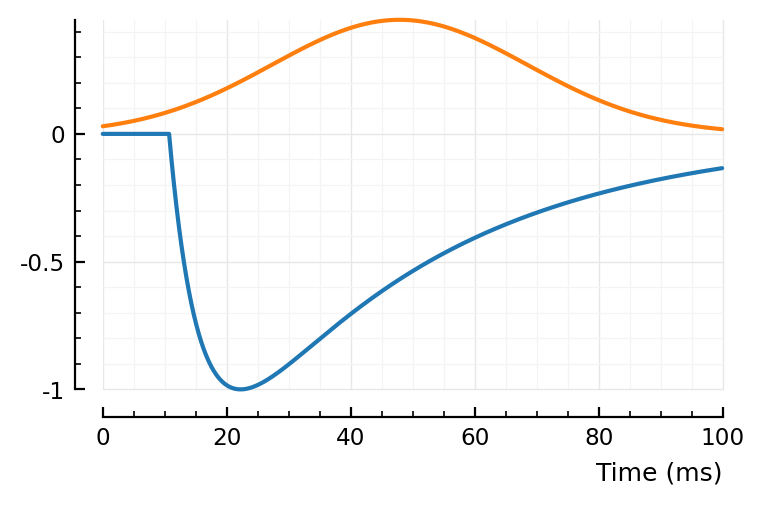

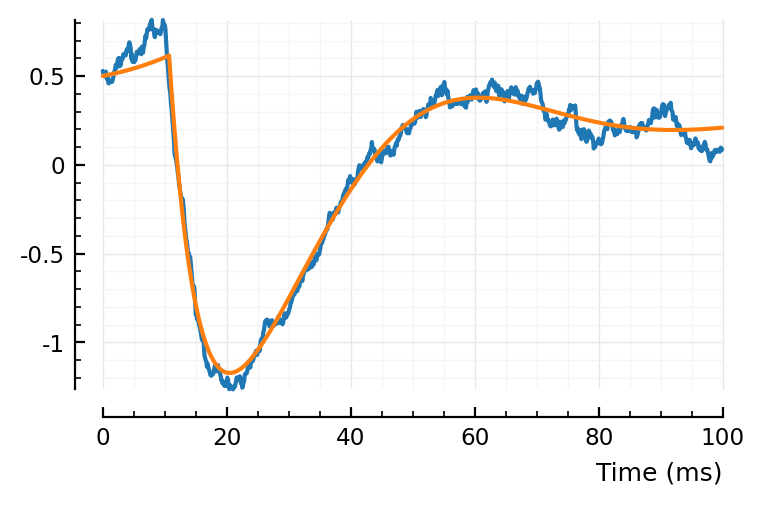

ComponentVector{Float64}(tx_delay = 0.0107, bump = (τ1 = 0.036, τ2 = 0.00504), dip = (loc = 0.0371, width = 1, weight = 0.447), scale = -0.002)

In [132]:
fit_STA(894);

The scale factor learning works well!

But hm, not as good a fit for this STA as in previous nb (under heading "Inh inputs").
The big dimple was better there. Is this an init problem?
Or is the problem that the actual width of the gaussian covaries with τ1+τ2 ?

Setting initial params for dip to ~what was found in previous nb:

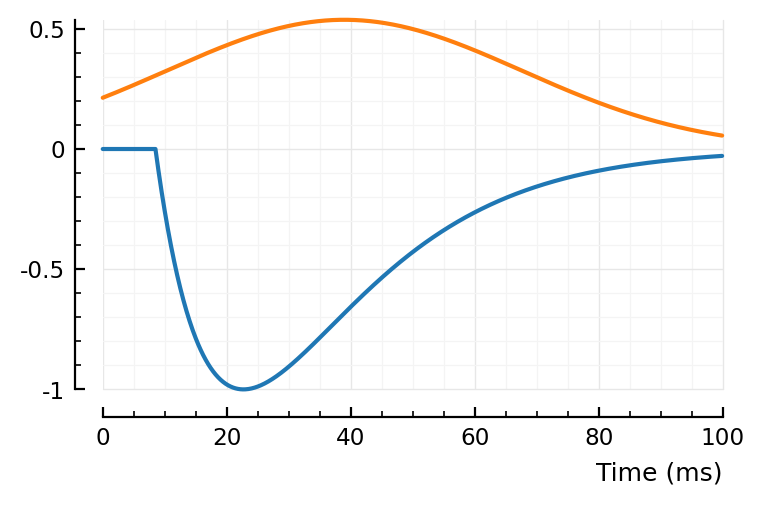

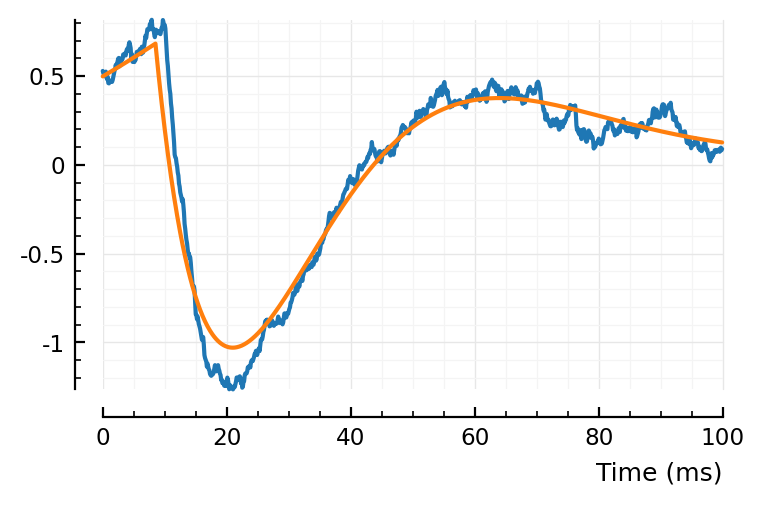

ComponentVector{Float64}(tx_delay = 0.00846, bump = (τ1 = 0.0133, τ2 = 0.0152), dip = (loc = 0.0305, width = 2.01, weight = 0.538), scale = -0.002)

In [134]:
p0b = copy(p0)
p0b.dip.loc = 25ms
p0b.dip.width = 2

fit_STA(894, p0b)

Hmmmm. So it is sensitive to initial parameters, very clear.

And still the prev fit was better. It can't all be due to that little extra gaussian dip.

I do suspect the coupling between dip.width and the bump time cts.

I did that btw to emulate the constraint that, vaguely, the gaussian dip cannot have a smaller timescale than the PSP bump.
Seeing that this algo/package only accepts box constraints, I solved it by making dip.width depend on the bump time cts.

(Similar reasoning for dip.loc, which is relative to tx_delay).

So, I'll clone ('fork') this notebook and edit the above params and modelling function to not have coupling anymore.
(Here, embedded edit history, live reconstruction of the nb, would be cool. History replay :).
Cause I can't just overwrite the above functions and plots, then that research is lost. But copying everything and editing only in a few places is noisy. I wish for better tooling).